In [1]:
import numpy as np
import pandas as pd
from scipy.stats import stats
from sklearn.linear_model import LinearRegression
import random
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from time import process_time


# Load in z-scored VE data 

In [77]:
# _dir = '/Users/pmahableshwarkar/Documents/Depth_Project'
_dir = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk'

VE_data_125_path = _dir + '/verbal_judgement_analysis/data/finalVEMatched/z_scored/z_scored_125_data.csv'

VE_data_250_path = _dir + '/verbal_judgement_analysis/data/finalVEMatched/z_scored/z_scored_250_data.csv'

VE_data_1000_path = _dir + '/verbal_judgement_analysis/data/finalVEMatched/z_scored/z_scored_1000_data.csv'

VE_data_125 = pd.read_csv(VE_data_125_path)
VE_data_250 = pd.read_csv(VE_data_250_path)
VE_data_1000 = pd.read_csv(VE_data_1000_path)

In [78]:
rm = ['Unnamed: 0', 'workerId', 'experimentName', 'versionName',
       'sequenceName', 'url', 'selected_row', 'windowWidth', 'windowHeight',
       'screenWidth', 'screenHeight', 'startDate', 'startTime', 'trial',
       'log_sceneDuration', 'unitSelection', 'seq_filepath', 'experimentTime',
       'totalTime', 'age', 'gender']

In [79]:
VE_data_125.drop(columns=rm, inplace=True)
VE_data_250.drop(columns=rm, inplace=True)
VE_data_1000.drop(columns=rm, inplace=True)

In [85]:
# make all duration dfs the same size 

smallest_num_rows = min(VE_data_125.shape[0], VE_data_250.shape[0], VE_data_1000.shape[0])

VE_data_125 = VE_data_125.sample(frac=1).reset_index(drop=True)
VE_data_250 = VE_data_250.sample(frac=1).reset_index(drop=True)
VE_data_1000 = VE_data_1000.sample(frac=1).reset_index(drop=True)

trunc_VE_data_125 = VE_data_250.truncate(after=smallest_num_rows-1)
trunc_VE_data_250 = VE_data_250.truncate(after=smallest_num_rows-1)
trunc_VE_data_1000 = VE_data_250.truncate(after=smallest_num_rows-1)


trunc_VE_data_125.shape[0], trunc_VE_data_250.shape[0], trunc_VE_data_1000.shape[0]

(23615, 23615, 23615)

In [90]:
def split_data(df):
    
    # shuffle df rows and reset index
    df = df.sample(frac=1 ).reset_index(drop=True)
    
    # if df has an odd number of 
    if df.shape[0]%2 == 1:
        df.drop(df.tail(1).index,inplace=True) # drop last n rows
    
#     print(df.shape[0])
    df_split = np.array_split(df, 2)
    
    return df_split[0], df_split[1]
        

In [91]:
s0_125, s1_125 = split_data(trunc_VE_data_125)
s0_250, s1_250 = split_data(trunc_VE_data_250)
s0_1000, s1_1000 = split_data(trunc_VE_data_1000)

In [96]:
s0_duration_data = [s0_125, s0_250, s0_1000]
s1_duration_data = [s1_125, s1_250, s1_1000]

In [97]:
def trial_pivotTable(data):
    """
    Generate pivot tables from data after cleaning and outlier removal 
    Organizes data such that for each individual target (stimulus) the following is calulated:
    - average depth estimation
    - standard deviation
    - standard error 
    """
    
    avg_tables = []
    std_tables = []
    result_tables = []
    ###### CREATE DF WITH DATA STATISTICS AFTER OUTLIER REMOVAL ######
    cond = 0
    for duration in data: #generate pivot tables for data statistics (avg, std, sem)
        actual = pd.pivot_table(duration,  values = ["actual_depth"], columns=['stimulus'], aggfunc=np.mean)
        actual.reset_index()
        actual_renamed = actual.rename(index={'actual_depth': 'Actual Depth'})
        
        avg = pd.pivot_table(duration,  values = ["depth_estimate"], columns=['stimulus'], aggfunc=np.mean)
        avg.reset_index()
        avg_renamed = avg.rename(index={'depth_estimate': 'Average Estimated Depth'})
        
        RT = pd.pivot_table(duration,  values = ["trial_RT"], columns=['stimulus'], aggfunc=np.mean)
        RT.reset_index()
        RT_renamed = RT.rename(index={'trial_RT': 'Average Trial RT'})
        
        std = pd.pivot_table(duration, values = ["depth_estimate"], columns = ["stimulus"], aggfunc = np.std)
        #note - std is normalized byN-1 by default (ddof parameter = 1 by default)
        std.reset_index()
        std_renamed = std.rename(index={'depth_estimate': 'Standard Deviation'})
        
        sem = pd.pivot_table(duration, values = ["depth_estimate"], columns = ["stimulus"], aggfunc = 'sem')
        sem.reset_index()
        sem_renamed = sem.rename(index={'depth_estimate': 'Standard Error'})
        
        frames = [avg_renamed, std_renamed, sem_renamed, actual_renamed, RT_renamed] #list of pivot tables for a given duration
        result = pd.concat(frames) #merge the pivot tables for a given duration 
        result = result.T #transpose 
        result = result.sort_values(by=['Actual Depth'])

        #Label the data by duration based on condition counter (cond)
        if cond == 0:
            result["Duration"] = 125
        if cond == 1:
            result["Duration"] = 250
        if cond == 2:
            result["Duration"] = 1000
        
        avg_tables.append(avg_renamed) #created for reference (not used in code)
        std_tables.append(std_renamed) #created for reference (not used in code)
        result_tables.append(result) #list of results for all durations 
        cond += 1 
        
    
    return result_tables

In [98]:
s0_zscored_trial_pivot = trial_pivotTable(s0_duration_data)
s1_zscored_trial_pivot = trial_pivotTable(s1_duration_data)


In [99]:
def trial_getxy(data):
    """
    Extracts the data from the dataframes to a list format for plotting. 
    Args:
        df = [125, 250, 1000]
        These data frames are POST all outlier cleaning. 
        
    Returns:
        actualdepths = [x_125, x_250, x_1000]
        xs = [list of individual targets]
        ys = [y_125, y_250, y_1000]
        stes = [ste_125, ste_250, ste_1000]
        
    """
    xs = []
    ys = []
    stes = []
    stds = []
    actualdepths = []
    trial_RTs = []
    for table in data:
        x = []
        y = []
        ste = []
        std = []
        depths = []
        RT = []
        for idx, row in table.iterrows():
            
            x.append(idx) #idx is the target (stimulus path)
            
            estim_avg = row["Average Estimated Depth"]
            y.append(estim_avg)
            
            standard_error = row["Standard Error"]
            ste.append(standard_error)
            
            depth = row["Actual Depth"]
            depths.append(depth)
            
            standard_deviation = row["Standard Deviation"]
            std.append(standard_deviation)       
            
            reactionTime = row["Average Trial RT"]
            RT.append(reactionTime)  
            
        xs.append(x)
        ys.append(y)
        stes.append(ste)
        actualdepths.append(depths)
        stds.append(std)
        trial_RTs.append(RT)

    return xs, ys, stes, actualdepths, stds, trial_RTs

In [100]:
s0_trial_zscored_final = trial_getxy(s0_zscored_trial_pivot)
s1_trial_zscored_final = trial_getxy(s1_zscored_trial_pivot)


In [104]:
data = {'s0_y_125': s0_trial_zscored_final[1][0],
's0_RT_125': s0_trial_zscored_final[5][0],
's0_y_250': s0_trial_zscored_final[1][1],
's0_RT_250': s0_trial_zscored_final[5][1],
's0_y_1000': s0_trial_zscored_final[1][2],
's0_RT_1000': s0_trial_zscored_final[5][2],
's1_y_125': s1_trial_zscored_final[1][0],
's1_RT_125': s1_trial_zscored_final[5][0],
's1_y_250': s1_trial_zscored_final[1][1],
's1_RT_250': s1_trial_zscored_final[5][1],
's1_y_1000': s1_trial_zscored_final[1][2],
's1_RT_1000': s1_trial_zscored_final[5][2]}

In [126]:
%%time
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor, wait, as_completed


dfs = [] 
    
def run_analysis():
    
    s0_125, s1_125 = split_data(trunc_VE_data_125)
    s0_250, s1_250 = split_data(trunc_VE_data_250)
    s0_1000, s1_1000 = split_data(trunc_VE_data_1000)
    
    s0_duration_data = [s0_125, s0_250, s0_1000]
    s1_duration_data = [s1_125, s1_250, s1_1000]
    
    s0_zscored_trial_pivot = trial_pivotTable(s0_duration_data)
    s1_zscored_trial_pivot = trial_pivotTable(s1_duration_data)
    
    s0_trial_zscored_final = trial_getxy(s0_zscored_trial_pivot)
    s1_trial_zscored_final = trial_getxy(s1_zscored_trial_pivot)
    

    data = {'s0_y_125': s0_trial_zscored_final[1][0],
            's0_RT_125': s0_trial_zscored_final[5][0],
            's0_y_250': s0_trial_zscored_final[1][1],
            's0_RT_250': s0_trial_zscored_final[5][1],
            's0_y_1000': s0_trial_zscored_final[1][2],
            's0_RT_1000': s0_trial_zscored_final[5][2],
            's1_y_125': s1_trial_zscored_final[1][0],
            's1_RT_125': s1_trial_zscored_final[5][0],
            's1_y_250': s1_trial_zscored_final[1][1],
            's1_RT_250': s1_trial_zscored_final[5][1],
            's1_y_1000': s1_trial_zscored_final[1][2],
            's1_RT_1000': s1_trial_zscored_final[5][2]}

    
    data_df = pd.DataFrame(data,columns=['s0_y_125', 's0_y_250', 's0_y_1000', 's0_RT_125', 's0_RT_250', 's0_RT_1000',
                                         's1_y_125', 's1_y_250', 's1_y_1000', 's1_RT_125', 's1_RT_250', 's1_RT_1000'])

    df_corr = data_df.corr()
    
    return df_corr    


reps = 5000
dfs = []


import multiprocessing as mp

executor = ProcessPoolExecutor(max_workers=mp.cpu_count()//4)
for i in range(reps):
#     print("Enqueuing run_analysis rep: ", i)
    dfs.append(executor.submit(run_analysis))

for count, future in enumerate(as_completed(dfs)):
    print("Rep completed :", count)
    
print(len(dfs))
    
df_sum = 0
for i, df in enumerate(dfs):
    df_sum += df.result()

mean_df_corr = df_sum / len(dfs)
executor.shutdown(wait=True)

mean_df_corr.to_csv('VE_avg_randSplitMatrix_n' + str(reps) + '.csv')

Rep completed : 0
Rep completed : 1
Rep completed : 2
Rep completed : 3
Rep completed : 4
Rep completed : 5
Rep completed : 6
Rep completed : 7
Rep completed : 8
Rep completed : 9
Rep completed : 10
Rep completed : 11
Rep completed : 12
Rep completed : 13
Rep completed : 14
Rep completed : 15
Rep completed : 16
Rep completed : 17
Rep completed : 18
Rep completed : 19
Rep completed : 20
Rep completed : 21
Rep completed : 22
Rep completed : 23
Rep completed : 24
Rep completed : 25
Rep completed : 26
Rep completed : 27
Rep completed : 28
Rep completed : 29
Rep completed : 30
Rep completed : 31
Rep completed : 32
Rep completed : 33
Rep completed : 34
Rep completed : 35
Rep completed : 36
Rep completed : 37
Rep completed : 38
Rep completed : 39
Rep completed : 40
Rep completed : 41
Rep completed : 42
Rep completed : 43
Rep completed : 44
Rep completed : 45
Rep completed : 46
Rep completed : 47
Rep completed : 48
Rep completed : 49
Rep completed : 50
Rep completed : 51
Rep completed : 52
Rep

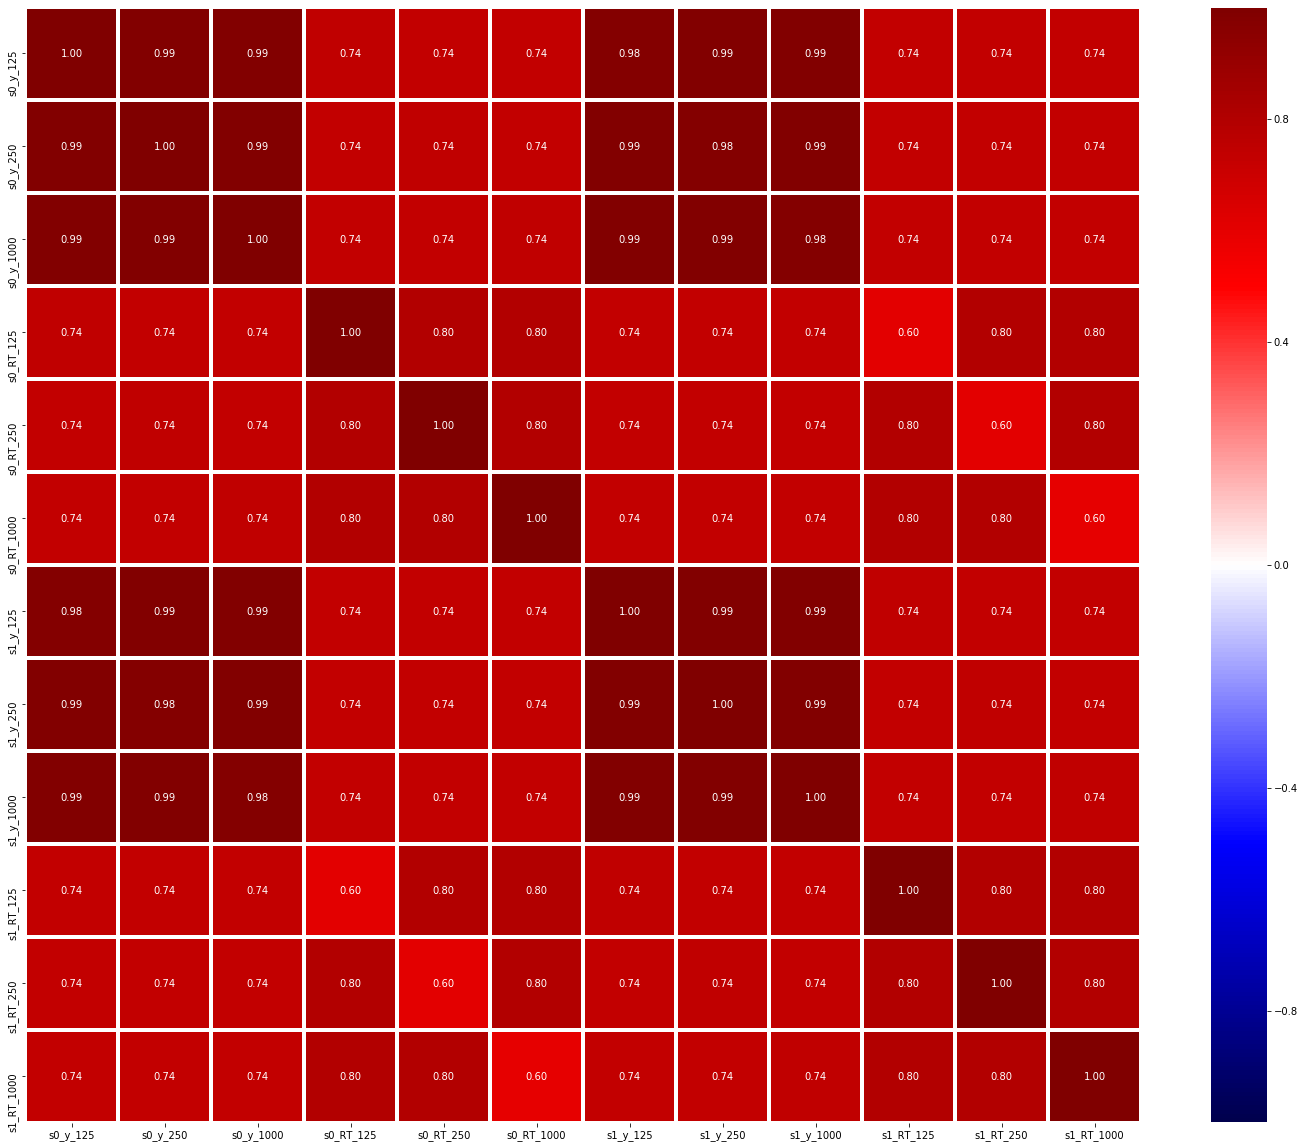

In [127]:
plt.figure(figsize=[25,25])

ax = sns.heatmap(mean_df_corr, annot=True, fmt=".2f", cmap= "seismic", square=True, center=0, vmin=-1, vmax=1, edgecolors='w', linewidths=3, cbar_kws={"shrink": .82}, ) #notation: "annot" not "annote"
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)


plt.show();

In [128]:
bottom_mean_df_corr = mean_df_corr.tail(6)
bottom_mean_df_corr = bottom_mean_df_corr.drop(columns = ['s1_y_125', 's1_y_250', 's1_y_1000',
                                                          's1_RT_125', 's1_RT_250', 's1_RT_1000'])

In [129]:
bottom_mean_df_corr

,s0_y_125,s0_y_250,s0_y_1000,s0_RT_125,s0_RT_250,s0_RT_1000
s1_y_125,0.981395,0.990575,0.990591,0.736649,0.739884,0.740367
s1_y_250,0.990569,0.981408,0.990594,0.739864,0.736763,0.740432
s1_y_1000,0.990583,0.990590,0.981411,0.739822,0.739813,0.736986
s1_RT_125,0.737609,0.740650,0.740794,0.602861,0.798170,0.798161
s1_RT_250,0.740431,0.737185,0.740381,0.799324,0.602159,0.798402
s1_RT_1000,0.739180,0.739085,0.735770,0.798471,0.797600,0.600410


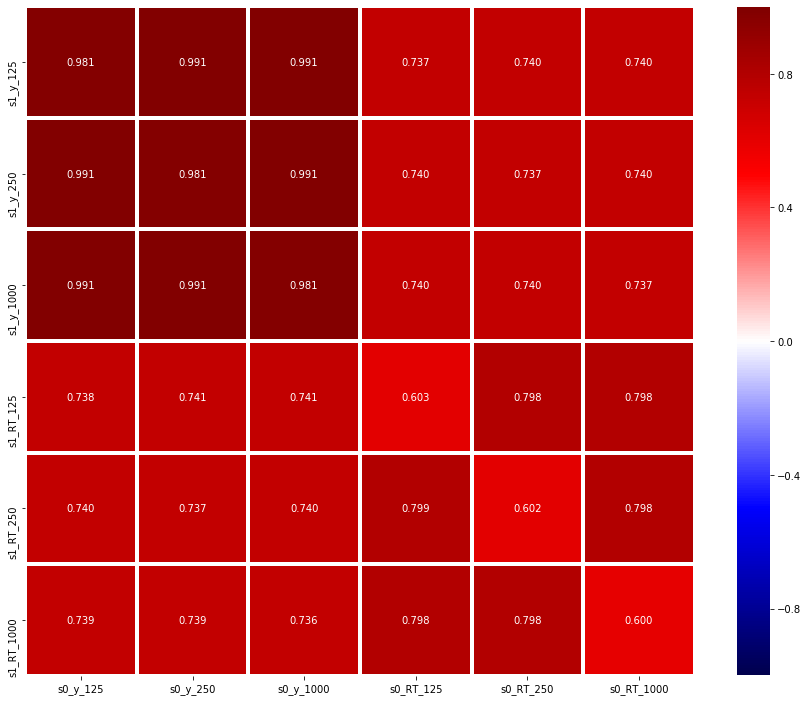

In [132]:
plt.figure(figsize=[15,15])

ax = sns.heatmap(bottom_mean_df_corr, annot=True, fmt=".3f", cmap= "seismic", square=True, center=0, vmin=-1, vmax=1, edgecolors='w', linewidths=3, cbar_kws={"shrink": .82}, ) #notation: "annot" not "annote"
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)


plt.savefig('rand_5000.png')
plt.show();


In [7]:
# r2_100_05 = generate_n_split_r2(100, zs_df, 0.5)
# r2_100_04 = generate_n_split_r2(100, zs_df, 0.4)
# r2_100_03 = generate_n_split_r2(100, zs_df, 0.3)
# r2_100_02 = generate_n_split_r2(100, zs_df, 0.2)

r2_100_05 = generate_n_split_r2(10, zs_df, 0.5)


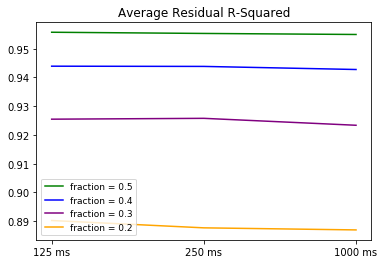

In [51]:
durations = ['125 ms', '250 ms', '1000 ms']
plt.plot(durations, r2_100_05[1], color = 'green', label= 'fraction = 0.5')
plt.plot(durations, r2_100_04[1], color = 'blue', label= 'fraction = 0.4')
plt.plot(durations, r2_100_03[1], color = 'purple', label= 'fraction = 0.3')
plt.plot(durations, r2_100_02[1], color = 'orange', label= 'fraction = 0.2')
plt.title('Average Residual R-Squared')
plt.legend(fontsize = 9)
plt.show()

Text(0.5, 1, 'Raw Split Residual R-Squared')

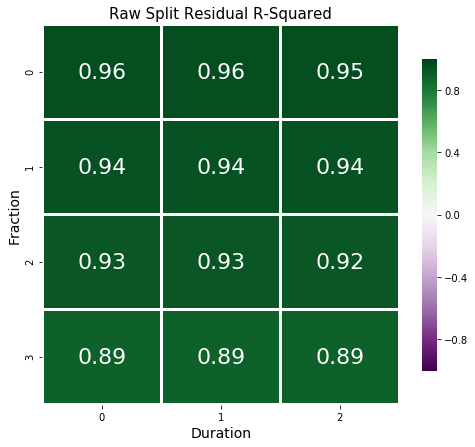

In [64]:
import seaborn as sns

plt.figure(figsize = [8, 7])
a = [r2_100_05[1], r2_100_04[1], r2_100_03[1], r2_100_02[1]]

ax = sns.heatmap(a, annot=True, fmt=".2f", annot_kws={"fontsize":22}, cmap= "PRGn", square=False, center=0, vmin=-1, vmax=1, edgecolors='w', linewidths=2, cbar_kws={"shrink": .82}) #notation: "annot" not "annote"
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

# ax = sns.heatmap(a, linewidth=0.5, annot=True, cmap='coolwarm')
# bottom, top = ax.get_ylim()
# ax.set_ylim(bottom + 0.5, top - 0.5)

plt.xlabel('Duration', fontsize = 14)

plt.ylabel('Fraction', fontsize = 14)



plt.title('Raw Split Residual R-Squared', fontsize = 15)